In [45]:
from torch import nn
import torch
print(torch.__version__)
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor


2.7.0


making a digit classifier using one layer neural network and comparing it with one built using cnn


In [46]:
#loading the datasets from mnist custom data in a regular manner
train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [47]:
#visualizing the data
print(type(train))
print(train.data.shape)#gives the imgs only
a=train[0]
print(a)


<class 'torchvision.datasets.mnist.MNIST'>
torch.Size([60000, 28, 28])
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

In [48]:
digits=train.classes
print(digits)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


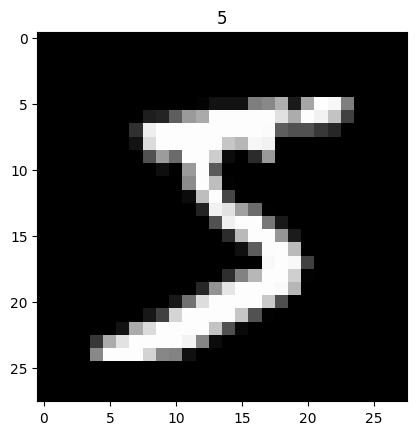

In [ ]:
import matplotlib.pyplot as plt
image, label = train[0]
plt.imshow(image.squeeze(),cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width),so to remove the extra dimension 1,image.squeeze->(28,28)
plt.title(label)

In [50]:
#use of torch.manual_seed
# Without setting a seed
print("No seed:")
print(torch.rand(3))  # Generates 3 random numbers
print(torch.rand(3))

# With seed ,basically sets the same starting point always
torch.manual_seed(42)
print("\nWith seed:")
print(torch.rand(3))  # These will be the same every time you run it

torch.manual_seed(42)
print(torch.rand(3))  # Re-setting the seed gives same output again

No seed:
tensor([0.3904, 0.6009, 0.2566])
tensor([0.7936, 0.9408, 0.1332])

With seed:
tensor([0.8823, 0.9150, 0.3829])
tensor([0.8823, 0.9150, 0.3829])


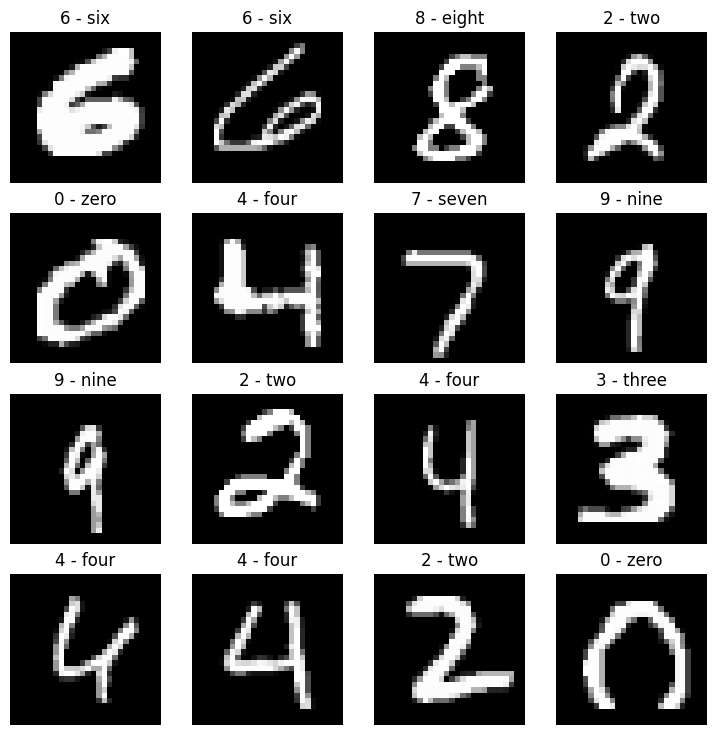

In [51]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train), size=[1]).item()
    img, label = train[random_idx]
    fig.add_subplot(rows, cols, i)#adding subplot for img
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(digits[label])
    plt.axis(False);

With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch(i.e. over the whole dataset) ).we don't use independant data,since that can cause large variance and overshooting.All data in mini batches are computed parallely

In [52]:
#preparing dataloader
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_data = DataLoader(train, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)
print(len(train_data))


test_data = DataLoader(test,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)
print(len(test_data))


1875
313


In [60]:
for batch, (X, y) in enumerate(train_data):
    print(f"Batch: {batch} | X shape: {X.shape} | y shape: {y.shape}")
    if batch == 0:
        break

Batch: 0 | X shape: torch.Size([32, 1, 28, 28]) | y shape: torch.Size([32])


In [53]:
print(train_data)
train_features_batch, train_labels_batch = next(iter(train_data))
print(train_features_batch.shape, train_labels_batch.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


backpropagation->just like chain rule dw/dx=dW/dy*dy/dx,you change the weights of hidden layer based on what should be value of output,and then of input layer based on hidden layer

In [ ]:
#define one layer linear neural network 
class digit_classifier(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), #flattens the pixels,reduces the dimension
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)
    
model=digit_classifier(input_shape=784,hidden_units=10,output_shape=10)
print(model) #gives the parameters of the model
#define accuracy and optimizer function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
epochs = 4

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_data):
        model.train() 
        # 1. Forward pass
        y_pred = model(X)  

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_data.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_data)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for X, y in test_data:
            # 1. Forward pass
            test_pred = model(X)     
           
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_data)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_data)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")#lr=

digit_classifier(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 25%|██▌       | 1/4 [00:03<00:11,  3.96s/it]


Train loss: 0.40561 | Test loss: 0.29465, Test acc: 91.58%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 50%|█████     | 2/4 [00:07<00:07,  3.65s/it]


Train loss: 0.30794 | Test loss: 0.28615, Test acc: 91.81%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 75%|███████▌  | 3/4 [00:10<00:03,  3.50s/it]


Train loss: 0.29560 | Test loss: 0.28648, Test acc: 91.89%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 4/4 [00:14<00:00,  3.60s/it]


Train loss: 0.29078 | Test loss: 0.28677, Test acc: 91.76%



In [55]:
#applying non-linearity to neural network 
class digit_classifier1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), #flattens the pixels,reduces the dimension
            nn.Linear(in_features=input_shape, out_features=hidden_units), 
            nn.ReLU(),#max(x,0)
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() # Adding non-linearity with ReLU activation function

        )

    def forward(self, x):
        return self.layer_stack(x)
    
model=digit_classifier1(input_shape=784,hidden_units=10,output_shape=10)
print(model) #gives the parameters of the model
#define accuracy and optimizer function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
epochs = 4

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_data):
        model.train() 
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_data.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_data)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for X, y in test_data:
            # 1. Forward pass
            test_pred = model(X)
           
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_data)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_data)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")#lr=

digit_classifier1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 25%|██▌       | 1/4 [00:04<00:12,  4.28s/it]


Train loss: 0.62218 | Test loss: 0.47458, Test acc: 85.06%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 50%|█████     | 2/4 [00:08<00:08,  4.19s/it]


Train loss: 0.40282 | Test loss: 0.27032, Test acc: 92.39%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 75%|███████▌  | 3/4 [00:11<00:03,  3.84s/it]


Train loss: 0.26528 | Test loss: 0.24858, Test acc: 92.73%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 4/4 [00:15<00:00,  3.81s/it]


Train loss: 0.24698 | Test loss: 0.23527, Test acc: 93.35%



This shows that for digit classification,the negative weights has a highly significant impact.

In [56]:
#lets see what happens if I increase one of the hidden units 
class digit_classifier2(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int,hidden_units2: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), #flattens the pixels,reduces the dimension
            nn.Linear(in_features=input_shape, out_features=hidden_units1), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units2, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)
    
model=digit_classifier2(input_shape=784,hidden_units1=50,hidden_units2=10,output_shape=10)
print(model) #gives the parameters of the model
#define accuracy and optimizer function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
epochs = 4

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_data):
        model.train() 
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_data.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_data)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for X, y in test_data:
            # 1. Forward pass
            test_pred = model(X)
           
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_data)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_data)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")#lr=

digit_classifier2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 25%|██▌       | 1/4 [00:04<00:13,  4.38s/it]


Train loss: 0.43459 | Test loss: 0.30496, Test acc: 91.28%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 50%|█████     | 2/4 [00:08<00:08,  4.12s/it]


Train loss: 0.32656 | Test loss: 0.29467, Test acc: 91.69%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 75%|███████▌  | 3/4 [00:12<00:04,  4.20s/it]


Train loss: 0.31192 | Test loss: 0.30231, Test acc: 91.42%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Train loss: 0.30744 | Test loss: 0.29512, Test acc: 91.88%



adding layer is also not of a large importance

Structured data (Excel spreadsheets, row and column data)->Gradient boosted models, Random Forests, XGBoost	sklearn.ensemble, XGBoost library
Unstructured data (images, audio, language)->Convolutional Neural Networks, Transformers	torchvision.models, HuggingFace Transformers


In [ ]:
# Create a convolutional neural network 
class digit_classifier(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # maximum value in each convolutional block (2x2 square of pixels->1x1 of output)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model = digit_classifier(input_shape=1, 
    hidden_units=10, 
    output_shape=10)
print(model) #gives the parameters of the model
#define accuracy and optimizer function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
epochs = 4

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_data):
        model.train() 
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_data.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_data)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for X, y in test_data:
            # 1. Forward pass
            test_pred = model(X)
           
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_data)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_data)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")#lr=


digit_classifier(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)
digit_classifier(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 25%|██▌       | 1/4 [00:41<02:05, 41.75s/it]


Train loss: 0.33272 | Test loss: 0.07398, Test acc: 97.60%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 50%|█████     | 2/4 [01:24<01:25, 42.57s/it]


Train loss: 0.08174 | Test loss: 0.06402, Test acc: 98.01%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 75%|███████▌  | 3/4 [02:03<00:40, 40.83s/it]


Train loss: 0.06413 | Test loss: 0.05497, Test acc: 98.15%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 4/4 [02:42<00:00, 40.61s/it]


Train loss: 0.05475 | Test loss: 0.05737, Test acc: 98.09%



so CNN model accuracy=98.09%


tensor([[ -9.0175,  -5.6315,  -0.1971,  18.0503,  -5.5038,   8.1694, -12.6162,
           0.6045,   3.6156,  -0.8242]])
3


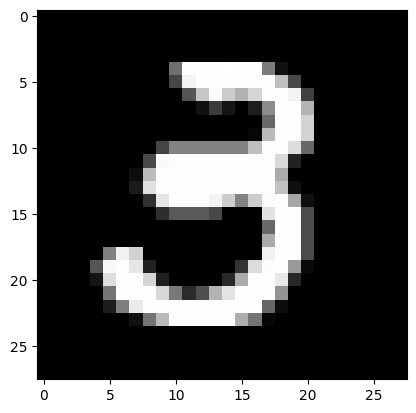

In [76]:
#seeing some predictions
import random
a=test[random.randint(0, len(test)-1)]
image, label = a
plt.imshow(image.squeeze(), cmap="gray")
model.eval()
with torch.inference_mode():
    image = image.unsqueeze(dim=0)  # Add batch dimension 
    pred = model(image)
    print(pred)
    # Get the index of the highest score
    pred_label = pred.argmax(dim=1).item()
    print(pred_label)  # Get the predicted label

